# Network in Network (NiN)

LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。
AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块。
或者，可以想象在这个过程的早期使用全连接层。然而，如果使用了全连接层，可能会完全放弃表征的空间结构。
*网络中的网络*（*NiN*）提供了一个非常简单的解决方案：在每个像素的通道上分别使用多层感知机

NiN块以一个普通卷积层开始，后面是两个$1 \times 1$的卷积层。这两个$1 \times 1$卷积层充当带有ReLU激活函数的逐像素全连接层。
第一层的卷积窗口形状通常由用户设置。
随后的卷积窗口形状固定为$1 \times 1$。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(inplace=True),
    )

NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层。
相反，NiN使用一个NiN块，其输出通道数等于标签类别的数量。最后放一个*全局平均汇聚层*（global average pooling layer），生成一个对数几率	（logits）。NiN设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模型的时间。

In [4]:
net = nn.Sequential(
    nin_block(1,96,kernel_size=11,strides=4,padding=0),
    nn.MaxPool2d(3,stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

In [5]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [6]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.341, train acc 0.873, test acc 0.881
1183.6 examples/sec on cuda:0


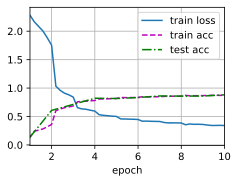

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())